In [1]:
# import some helpful python packages 
import os
import numpy as np

from astropy.io import fits
from astropy.table import Table
from astropy.convolution import convolve, Gaussian1DKernel

import matplotlib 
import matplotlib.pyplot as plt

%matplotlib inline

import fitsio

from io import BytesIO
import requests
import numpy as np 
from PIL import Image

def load_image(url):
    res = requests.get(url)
    img_arr = np.array(Image.open(BytesIO(res.content)))
    return img_arr

import src.plotting_tools as plt_tools

outpath = './catalog/'

In [2]:
# import DESI related modules - 
from desimodel.footprint import radec2pix      # For getting healpix values
import desispec.io                             # Input/Output functions related to DESI spectra
from desispec import coaddition                # Functions related to coadding the spectra

from desitarget.targetmask import desi_mask, bgs_mask, scnd_mask    # For the main survey
#from desitarget.sv1.sv1_targetmask import desi_mask, bgs_mask, scnd_mask    # For SV1
#from desitarget.sv2.sv2_targetmask import desi_mask, bgs_mask, scnd_mask    # For SV2
# from desitarget.sv3.sv3_targetmask import desi_mask, bgs_mask, scnd_mask    # For SV3

In [ ]:
# Release directory path
specprod = 'everest'
release_dir = f'/global/cfs/cdirs/desi/spectro/redux/{specprod}'
survey = 'main'
faprgrms = ['dark','bright']

TIDS = []

for faprgrm in faprgrms:
    zcat = Table.read(f'{release_dir}/zcatalog/zpix-{survey}-{faprgrm}.fits', hdu="ZCATALOG")
    
    # Targeting information about the DESI targetting is stored in the desi_target columns - 
    desi_target = zcat['DESI_TARGET']

    # Masks for different targets
    bgs_tgtmask = desi_mask['BGS_ANY']    
    is_bgs = (desi_target & bgs_tgtmask != 0)
    
    # Number of sources of each target type
    n_bgs = sum(is_bgs)
    
    print(n_bgs)
    k = 0    
    
    healpix_dir = f'{release_dir}/healpix'
    hpxs = np.array(radec2pix(nside=64, ra=zcat['TARGET_RA'].data[is_bgs], dec=zcat['TARGET_DEC'].data[is_bgs])).astype(str)
   
    TARGETIDS = zcat['TARGETID'].data[is_bgs]
    plt_tools.plot_skymap(zcat['TARGET_RA'].data[is_bgs], zcat['TARGET_DEC'].data[is_bgs], zcat['TARGET_RA'].data[is_bgs], field_str='Redshift', title='Map')    
    
    COADD = []
    
    for hpx in np.unique(hpxs)[:2]:
        tgt_dir = f'{healpix_dir}/{survey}/{faprgrm}/{hpx[:-2]}/{hpx}'
        coadd_filename = f'coadd-{survey}-{faprgrm}-{hpx}.fits'
        
        coadd_obj = desispec.io.read_spectra(f'{tgt_dir}/{coadd_filename}')
        coadd_tgts = coadd_obj.target_ids().data
        
        # print(coadd_tgts)
    
        for i, tid in enumerate(TARGETIDS):
            if tid in coadd_tgts:
                TIDS.append(tid)
                
                s_filename = f'spectra-{survey}-{faprgrm}-{hpx}.fits'
                h_spec = fits.open(f'{tgt_dir}/{s_filename}')['FIBERMAP'].data

                TARGETID = np.array(h_spec['TARGETID'])
                ii = TARGETID == tid
                TILE = np.array(h_spec['TILEID'])[ii][0]
                PETAL = np.array(h_spec['PETAL_LOC'])[ii][0]
                EXPID = np.array(h_spec['EXPID'])[ii][0]
                FIBER = np.array(h_spec['FIBER'])[ii][0]
                NIGHT = np.array(h_spec['NIGHT'])[ii][0]
                MJD = np.array(h_spec['MJD'])[ii][0]
                TARGET_RA = np.array(h_spec['TARGET_RA'], dtype=str)[ii][0]
                TARGET_DEC = np.array(h_spec['TARGET_DEC'], dtype=str)[ii][0]
                
                z_filename = f'redrock-{survey}-{faprgrm}-{hpx}.fits'
                h_rr = fits.open(f'{tgt_dir}/{z_filename}')['REDSHIFTS'].data

                TARGETID = np.array(h_rr['TARGETID'])
                ii = TARGETID == tid
                Z = np.array(h_rr['Z'])[ii][0]
                ZERR = np.array(h_rr['ZERR'])[ii][0]
                ZWARN = np.array(h_rr['ZWARN'])[ii][0]
                SPECTYPE = np.array(h_rr['SPECTYPE'])[ii][0]
                SUBTYPE = np.array(h_rr['SUBTYPE'])[ii][0]
                
                
                row = (coadd_tgts == tid)
                coadd_spec = coadd_obj[row]

                FLUX_B = coadd_spec.flux['b'][0]
                FLUX_R = coadd_spec.flux['r'][0]
                FLUX_Z = coadd_spec.flux['z'][0]

                WAVE_B = coadd_spec.wave['b']
                WAVE_R = coadd_spec.wave['r']
                WAVE_Z = coadd_spec.wave['z']

                spec_combined = coaddition.coadd_cameras(coadd_spec)

                FLUX_BRZ = spec_combined.flux['brz'][0]
                WAVE_BRZ = spec_combined.wave['brz']
                
                url_g = 'https://www.legacysurvey.org/viewer/jpeg-cutout?ra={}&dec={}&layer=ls-dr9-north&pixscale=0.27&bands=g'.format(TARGET_RA,TARGET_DEC)
                IMAGE_G = load_image(url_g)

                url_r = 'https://www.legacysurvey.org/viewer/jpeg-cutout?ra={}&dec={}&layer=ls-dr9-north&pixscale=0.27&bands=r'.format(TARGET_RA,TARGET_DEC)
                IMAGE_R = load_image(url_r)

                url_z = 'https://www.legacysurvey.org/viewer/jpeg-cutout?ra={}&dec={}&layer=ls-dr9-north&pixscale=0.27&bands=z'.format(TARGET_RA,TARGET_DEC)
                IMAGE_Z = load_image(url_z)
                
                url_grz = 'https://www.legacysurvey.org/viewer/jpeg-cutout?ra={}&dec={}&layer=ls-dr9-north&pixscale=0.27&bands=grz'.format(TARGET_RA,TARGET_DEC)
                IMAGE_GRZ = load_image(url_grz)                
                
                if k==0:
                    fig = plt.figure(figsize=(15,15))
                    plt.subplot(2,2,1)
                    plt.imshow(IMAGE_G)
                    
                    plt.subplot(2,2,2)
                    plt.imshow(IMAGE_R)
                    
                    plt.subplot(2,2,3)
                    plt.imshow(IMAGE_Z)                    
                    
                    plt.subplot(2,2,4)
                    plt.imshow(IMAGE_GRZ)
                    
                    plt.show()
                
                if float(TARGET_DEC)>0:
                    filename = '{}/DESI_{}+{}.fits'.format(outpath,TARGET_RA,TARGET_DEC)
                else:
                    filename = '{}/DESI_{}{}.fits'.format(outpath,TARGET_RA,TARGET_DEC)
                
                hdict = {'TARGETID':tid, 'TARGET_RA':TARGET_RA, 'TARGET_DEC':TARGET_DEC, 
                        'TILEID':TILE, 'TILEID':FIBER, 'PETAL_LOC':PETAL, 'EXPID':EXPID,
                        'NIGHT':NIGHT, 'MJD':MJD, 'Z':Z, 'ZERR':ZERR,
                        'ZWARN':ZWARN, 'SPECTYPE':SPECTYPE, 'SUBTYPE':SUBTYPE}
                
                data = {'FLUX_B':FLUX_B, 'WAVE_B':WAVE_B}
                fitsio.write(filename, data, header=hdict)
                
                data = {'FLUX_R':FLUX_R, 'WAVE_R':WAVE_R}
                fitsio.write(filename, data, header=hdict)
                
                data = {'FLUX_Z':FLUX_Z, 'WAVE_Z':WAVE_Z}
                fitsio.write(filename, data, header=hdict)                
                
                data = {'FLUX_BRZ':FLUX_BRZ, 'WAVE_BRZ':WAVE_BRZ}
                fitsio.write(filename, data, header=hdict)
                
                
                fitsio.write(filename, IMAGE_G, header=hdict)
                
                fitsio.write(filename, IMAGE_R, header=hdict)
                
                fitsio.write(filename, IMAGE_Z, header=hdict)

                fitsio.write(filename, IMAGE_GRZ, header=hdict)
                
                k +=1
print(k)

In [ ]:
# float(TARGET_DEC)

In [ ]:
# fig = plt.figure(figsize=(5,2))
# plt.subplot(121)
# plt.plot(WAVE_B, FLUX_B, color = 'b', alpha = 0.5)
# plt.plot(WAVE_R, FLUX_R, color = 'g', alpha = 0.5)        
# plt.plot(WAVE_Z, FLUX_Z, color = 'r', alpha = 0.5)
# plt.subplot(122)
# plt.plot(WAVE_BRZ, FLUX_BRZ, color = 'r', alpha = 0.5)
# fig.suptitle('TID:{} - SPECTYPE: {} - Z:{}'.format(tid, SPECTYPE[i], Z[i]))
# plt.show()

In [ ]:
# s_filename = f'spectra-{survey}-{faprgrm}-{hpx}.fits'
# h_spec = fits.open(f'{tgt_dir}/{s_filename}')
# h_spec['FIBERMAP'].columns
# h_spec['Z_FLUX'].data
# h_spec.info()

# z_filename = f'redrock-{survey}-{faprgrm}-{hpx}.fits'
# h_rr = fits.open(f'{tgt_dir}/{z_filename}')
# h_rr['REDSHIFTS'].columns

In [ ]:
# TARGETID

In [ ]:
# values, counts  = np.unique(COADD, return_counts=True)
# data = pd.DataFrame(np.array([values, counts]).T, columns=['TID','Times'])
# data

In [ ]:
# values

In [ ]:
# np.unique(counts)

In [ ]:
# j = 0
# for hpx in np.unique(hpxs):
#         tgt_dir = f'{healpix_dir}/{survey}/{faprgrm}/{hpx[:-2]}/{hpx}'
#         coadd_filename = f'coadd-{survey}-{faprgrm}-{hpx}.fits'
        
#         # h_coadd = fits.open(f'{tgt_dir}/{coadd_filename}')
#         # h_coadd.info()

#         coadd_obj = desispec.io.read_spectra(f'{tgt_dir}/{coadd_filename}')
#         coadd_tgts = coadd_obj.target_ids().data
#         j += len(coadd_tgts)

In [ ]:
# j

In [ ]:
# Table(h_rr['REDSHIFTS'].columns)

In [ ]:
# np.shape(coadd_tgts)

In [ ]:
# np.shape(targets)

In [ ]:
# zcat

In [ ]:
# import some helpful python packages 
import os
import numpy as np

from astropy.io import fits
from astropy.table import Table
from astropy.convolution import convolve, Gaussian1DKernel

import matplotlib 
import matplotlib.pyplot as plt

In [ ]:
# import DESI related modules - 
from desimodel.footprint import radec2pix      # For getting healpix values
import desispec.io                             # Input/Output functions related to DESI spectra
from desispec import coaddition                # Functions related to coadding the spectra

# DESI targeting masks - 
from desitarget.sv1 import sv1_targetmask    # For SV1
from desitarget.sv2 import sv2_targetmask    # For SV2
from desitarget.sv3 import sv3_targetmask    # For SV3

In [ ]:
# Release directory path
specprod = 'fuji'    # Internal name for the EDR
specprod_dir = desispec.io.specprod_root(specprod)
healpix_dir = f'{specprod_dir}/healpix'

In [ ]:
exp_table = Table.read(f'{specprod_dir}/exposures-{specprod}.fits', hdu='EXPOSURES')
exp_table

In [ ]:
zpix_cat = Table.read(f'{specprod_dir}/zcatalog/zall-pix-{specprod}.fits', hdu="ZCATALOG")
zpix_cat

In [ ]:
# Targeting information about the DESI targetting is stored in the different desi_target columns
sv1_desi_tgt = zpix_cat['SV1_DESI_TARGET']
sv2_desi_tgt = zpix_cat['SV2_DESI_TARGET']
sv3_desi_tgt = zpix_cat['SV3_DESI_TARGET']

sv1_desi_mask = sv1_targetmask.desi_mask
sv2_desi_mask = sv2_targetmask.desi_mask
sv3_desi_mask = sv3_targetmask.desi_mask

In [ ]:
sv1_desi_mask['BGS_ANY']

In [ ]:
## All BGS targets from sv1, sv2, and sv3
# is_bgs = (sv1_desi_tgt & sv1_desi_mask['BGS_ANY'] != 0)|(sv2_desi_tgt & sv2_desi_mask['BGS_ANY'] != 0)|(sv3_desi_tgt & sv3_desi_mask['BGS_ANY'] != 0)
is_bgs = (sv3_desi_tgt & sv3_desi_mask['BGS_ANY'] != 0)
## All LRG targets from sv1, sv2, and sv3
# is_lrg = (sv1_desi_tgt & sv1_desi_mask['LRG'] != 0)|(sv2_desi_tgt & sv2_desi_mask['LRG'] != 0)|(sv3_desi_tgt & sv3_desi_mask['LRG'] != 0)
# ## All ELG targets from sv1, sv2, and sv3
# is_elg = (sv1_desi_tgt & sv1_desi_mask['ELG'] != 0)|(sv2_desi_tgt & sv2_desi_mask['ELG'] != 0)|(sv3_desi_tgt & sv3_desi_mask['ELG'] != 0)
# ## All QSO targets from sv1, sv2, and sv3
# is_qso = (sv1_desi_tgt & sv1_desi_mask['QSO'] != 0)|(sv2_desi_tgt & sv2_desi_mask['QSO'] != 0)|(sv3_desi_tgt & sv3_desi_mask['QSO'] != 0)
# ## All MWS targets from sv1, sv2, and sv3
# is_mws = (sv1_desi_tgt & sv1_desi_mask['MWS_ANY'] != 0)|(sv2_desi_tgt & sv2_desi_mask['MWS_ANY'] != 0)|(sv3_desi_tgt & sv3_desi_mask['MWS_ANY'] != 0)
# ## All Secondary targets from sv1, sv2, and sv3
# is_scnd = (sv1_desi_tgt & sv1_desi_mask['SCND_ANY'] != 0)|(sv2_desi_tgt & sv2_desi_mask['SCND_ANY'] != 0)|(sv3_desi_tgt & sv3_desi_mask['SCND_ANY'] != 0)

In [ ]:
# Selecting the primary spectra - 
is_primary = zcat_sel['ZCAT_PRIMARY']

zpix_cat[is_bgs & is_primary]

In [ ]:
# Selecting a random object which has multiple spectra in DESI
targets = np.unique(zpix_cat['TARGETID'][is_bgs])

for targetid in targets[:2]:
    # Selecting the redshift catalogs rows for the particular targetid
    rows = zpix_cat['TARGETID'] == targetid
    zcat_sel = zpix_cat[rows]

    # Information needed to access the spectra 
    survey = zcat_sel['SURVEY'].astype(str)[0]
    program = zcat_sel['PROGRAM'].astype(str)[0]
    hpx = zcat_sel['HEALPIX'][0]    ## This is same for all the rows, given its the same TARGET. But, just to be consistent.

    tgt_dir = f'{healpix_dir}/{survey}/{program}/{hpx//100}/{hpx}'
    
    z_filename = f'redrock-{survey}-{program}-{hpx}.fits'
    coadd_filename = f'coadd-{survey}-{program}-{hpx}.fits'
    
    # Using desispec to read the spectra
    coadd_obj = desispec.io.read_spectra(f'{tgt_dir}/{coadd_filename}')
    coadd_tgts = coadd_obj.target_ids().data
    
    # Selecting the particular spectra of the targetid
    row = (coadd_tgts == targetid)
    coadd_spec = coadd_obj[row]
    
    WAVE_B = coadd_spec.wave['b']
    WAVE_R = coadd_spec.wave['r']
    WAVE_Z = coadd_spec.wave['z']
    
    FLUX_B = coadd_spec.flux['b'][0]
    FLUX_R = coadd_spec.flux['r'][0]
    FLUX_Z = coadd_spec.flux['z'][0]
    
    spec_combined = coaddition.coadd_cameras(coadd_spec)
    WAVE_BRZ = spec_combined.wave['brz']
    FLUX_BRZ = spec_combined.flux['brz'][0]
    
    plt.figure(figsize = (20, 6))
    # Plot the combined spectrum in maroon
    plt.plot(WAVE_BRZ, FLUX_BRZ, color = 'maroon', alpha = 0.5)
    # Over-plotting smoothed spectra 
    plt.plot(WAVE_BRZ, convolve(FLUX_BRZ, Gaussian1DKernel(5)), color = 'k', lw = 2.0)
    plt.xlim([3500, 9900])
    plt.xlabel('$\lambda$ [$\AA$]')
    plt.ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
    plt.show()    

In [ ]:
print(tgt_dir)
z_cat = Table.read(f'{tgt_dir}/{z_filename}')
z_cat

In [ ]:
tgt_dir,os.listdir(tgt_dir)

In [ ]:
import pylab as pl

In [ ]:
# import os
# import numpy as np
# from   glob import glob
# import fitsio
# import pandas as pd
# import desispec.io
# from   tqdm.notebook import tqdm

# from   io import BytesIO
# import requests
# from   PIL import Image

# def load_image(url): 
#     res = requests.get(url)
#     img_arr = np.array(Image.open(BytesIO(res.content)))
#     return img_arr

# def create(release, survey, clss, phys_targets, night, tile, overwrite):
    
#     #- Define the path of the data by release
#     path = f'/global/cfs/cdirs/desi/spectro/redux/{release}/tiles/pernight'
    
#     #- Define the output path
#     outpath = f'./catalog_{release}_{survey}_{clss}'
#     if os.path.isdir(outpath) == False:
#         os.makedirs(outpath+'/npy/', exist_ok=True)
    
#     #- Create a temporal catalog that contains the objects created
#     cat_file = f'./catalog_{release}_{survey}_{clss}_files.csv'
    
#     #- If overwrite == 'yes' the catalog creation start from 0%
#     if overwrite == 'yes':
#         catalog_files = pd.DataFrame(columns=['file'])
#         catalog_files.to_csv(cat_file, index=False)
        
#     #- Columns from the spectra files
#     scolumns = ['TARGETID','NIGHT','TILEID','PETAL_LOC','EXPID','FIBER','MJD','TARGET_RA','TARGET_DEC','FIBERSTATUS',
#                 'FLUX_IVAR_B','FLUX_IVAR_R','FLUX_IVAR_Z','FLUX_IVAR_BRZ', 'FLUX_B','FLUX_R','FLUX_Z','FLUX_BRZ',
#                 'SUMFLUX_B','SUMFLUX_R','SUMFLUX_Z','SUMFLUX_BRZ']
    
#     #- Columns from the zcatalog files
#     zcolumns = ['TARGETID','Z','ZERR','SPECTYPE']

#     #- Find the spectra files to iterate
#     sfiles = np.sort(glob(f'{path}/{tile}/{night}/spectra*.fits'))

#     #- Iterate between spectra files
#     for sfile in sfiles:
        
#         #- Read the temporal file that contains the objects created
#         catalog_files = pd.read_csv(cat_file)
 
#         #- Ignore if the spectrafile is into the catalog.csv file
#         if sfile in list(catalog_files['file']):
#             None
#         else:
#             # try:
#             #- Read Spectra file
#             sp = desispec.io.read_spectra(sfile)
#             sp_pd = sp.fibermap.to_pandas()
            
            
#             print(sfile)
#             print(sp_pd.keys())
#             # print(sp_pd['FLUX_IVAR_G'])
#             # print(sp_pd['FLUX_IVAR_R'])
#             # print(sp_pd['FLUX_IVAR_Z'])
            
#             #- Extract all the FLUX
#             sp_pd['FLUX_B'] = [i for i in sp.flux['b']]
#             sp_pd['FLUX_R'] = [i for i in sp.flux['r']]
#             sp_pd['FLUX_Z'] = [i for i in sp.flux['z']]
#             sp_pd['FLUX_BRZ'] = [np.concatenate([x,y,z])  for x,y,z in zip(sp.flux['b'], sp.flux['r'], sp.flux['z'])]       
            
#             #- Concatenate IVAR
#             sp_pd['FLUX_IVAR_B'] = [i for i in sp.ivar['b']]
#             sp_pd['FLUX_IVAR_R'] = [i for i in sp.ivar['r']]
#             sp_pd['FLUX_IVAR_Z'] = [i for i in sp.ivar['z']]
#             sp_pd['FLUX_IVAR_BRZ'] = [np.concatenate([x,y,z])  for x,y,z in zip(sp.ivar['b'], sp.ivar['r'], sp.ivar['z'])]       

            
#             #- Compute the sum of the flux to identify null flux
#             sum_flux_b = [sum(i) for i in sp_pd['FLUX_B']]
#             sum_flux_r = [sum(i) for i in sp_pd['FLUX_R']]
#             sum_flux_z = [sum(i) for i in sp_pd['FLUX_Z']]
#             sum_flux_brz = [sum(i) for i in sp_pd['FLUX_BRZ']]

#             #- Save the sum flux
#             sp_pd['SUMFLUX_B'] = sum_flux_b
#             sp_pd['SUMFLUX_R'] = sum_flux_r
#             sp_pd['SUMFLUX_Z'] = sum_flux_z
#             sp_pd['SUMFLUX_BRZ'] = sum_flux_brz

#             #- Read the Zcatalog file (or redrock)
#             zfile = sfile.replace('spectra','redrock')
#             zs = fitsio.read(zfile)

#             s_temp = sp_pd[scolumns]
#             z_temp = pd.DataFrame(zs[zcolumns].byteswap().newbyteorder(), columns=zcolumns)

#             #- Merge Spectra and zcatalog file
#             df_spec = pd.merge(s_temp, z_temp)
            
#             #- Merge with PHYSICAL_TARGETS
#             df_spec = pd.merge(df_spec, phys_targets, on=['TARGETID'])            

#             # print(df_spec['FLUX_IVAR_B'])
#             # except:
#             #     print(f'Error reading {sfile}')

#             #- Ignore if df_spec is null 
#             if len(df_spec) > 0:
#                 df_spec = df_spec[~df_spec.astype(str).duplicated()]
                
#                 #- Apply some filters
#                 df_spec = df_spec[df_spec['FIBERSTATUS'] == 0]
#                 df_spec = df_spec[df_spec['SUMFLUX_B'] != 0]
#                 df_spec = df_spec[df_spec['SUMFLUX_R'] != 0]
#                 df_spec = df_spec[df_spec['SUMFLUX_Z'] != 0]
#                 df_spec = df_spec[df_spec['SUMFLUX_BRZ'] != 0]
#                 df_spec = df_spec.drop(['SUMFLUX_B','SUMFLUX_R','SUMFLUX_Z','SUMFLUX_BRZ','FIBERSTATUS'], axis=1)

#                 wave_b = sp.wave['b']
#                 wave_r = sp.wave['r']
#                 wave_z = sp.wave['z']
#                 wave_brz = np.concatenate([sp.wave['b'],sp.wave['r'],sp.wave['z']])

#                 # pbar = tqdm(total=len(df_spec), desc=sfile)
#                 for i in range(len(df_spec)):
#                     tid        = np.array(df_spec['TARGETID'])[i]
#                     target_ra  = np.array(df_spec['TARGET_RA'])[i]
#                     target_dec = np.array(df_spec['TARGET_DEC'])[i]
#                     tileid     =  np.array(df_spec['TILEID'])[i]
#                     fiber      = np.array(df_spec['FIBER'])[i]
#                     petal_loc  = np.array(df_spec['PETAL_LOC'])[i]
#                     expid      = np.array(df_spec['EXPID'])[i]
#                     night      = np.array(df_spec['NIGHT'])[i]
#                     mjd        = np.array(df_spec['MJD'])[i]
#                     z          = np.array(df_spec['Z'])[i]
#                     zerr       = np.array(df_spec['ZERR'])[i]
#                     spectype   = np.array(df_spec['SPECTYPE'])[i]
#                     flux_b     = np.array(df_spec['FLUX_B'])[i]
#                     flux_r     = np.array(df_spec['FLUX_R'])[i]
#                     flux_z     = np.array(df_spec['FLUX_Z'])[i]
#                     flux_brz   = np.array(df_spec['FLUX_BRZ'])[i]
#                     flux_ivar_b    = np.array(df_spec['FLUX_IVAR_B'])[i]
#                     flux_ivar_r    = np.array(df_spec['FLUX_IVAR_R'])[i]
#                     flux_ivar_z    = np.array(df_spec['FLUX_IVAR_Z'])[i]                    
#                     flux_ivar_brz  = np.array(df_spec['FLUX_IVAR_BRZ'])[i]

                    
#                     phys_targets_keys = ['CONTINUUM_Z', 'LOGL_5100', 'LOGMSTAR', 'ABSMAG_U', 'ABSMAG_B', 'ABSMAG_V',
#                                          'ABSMAG_SDSS_U', 'ABSMAG_SDSS_G','ABSMAG_SDSS_R', 'ABSMAG_SDSS_I', 'ABSMAG_SDSS_Z']                    
#                     phys_features = np.array(df_spec[phys_targets_keys])[i]               

#                     if float(target_dec)>0:
#                         filename = f'{outpath}/DESI_{tid}_{tileid}_{target_ra}+{target_dec}.fits'
#                     else:
#                         filename = f'{outpath}/DESI_{tid}_{tileid}_{target_ra}{target_dec}.fits'
                    
#                     #- If the file exists, then do nothing. Else download the images and create the fits file
#                     if os.path.isfile(filename):
#                         None
#                     else:
#                         try:
#                             url_g = 'https://www.legacysurvey.org/viewer/jpeg-cutout?ra={}&dec={}&layer=ls-dr9&pixscale=0.27&bands=g'.format(target_ra,target_dec)
#                             image_g = load_image(url_g)

#                             url_r = 'https://www.legacysurvey.org/viewer/jpeg-cutout?ra={}&dec={}&layer=ls-dr9&pixscale=0.27&bands=r'.format(target_ra,target_dec)
#                             image_r = load_image(url_r)

#                             url_z = 'https://www.legacysurvey.org/viewer/jpeg-cutout?ra={}&dec={}&layer=ls-dr9&pixscale=0.27&bands=z'.format(target_ra,target_dec)
#                             image_z = load_image(url_z)

#                             url_grz = 'https://www.legacysurvey.org/viewer/jpeg-cutout?ra={}&dec={}&layer=ls-dr9&pixscale=0.27&bands=grz'.format(target_ra,target_dec)
#                             image_grz = load_image(url_grz)                

#                             hdict = {'TARGETID':tid, 'TARGET_RA':target_ra, 'TARGET_DEC':target_dec, 
#                                     'TILEID':tileid, 'FIBER':fiber, 'PETAL_LOC':petal_loc, 'EXPID':expid,
#                                     'NIGHT':night, 'MJD':mjd, 'Z':z, 'ZERR':zerr, 'SPECTYPE':spectype}

#                             data = {'FLUX_B':flux_b, 'WAVE_B':wave_b, 'FLUX_IVAR_B':flux_ivar_b}
#                             fitsio.write(filename, data, header=hdict)

#                             data = {'FLUX_R':flux_r, 'WAVE_R':wave_r, 'FLUX_IVAR_R':flux_ivar_r}
#                             fitsio.write(filename, data, header=hdict)

#                             data = {'FLUX_Z':flux_z, 'WAVE_Z':wave_z, 'FLUX_IVAR_Z':flux_ivar_z}
#                             fitsio.write(filename, data, header=hdict)                

#                             data = {'FLUX_BRZ':flux_brz, 'WAVE_BRZ':wave_brz, 'FLUX_IVAR_BRZ':flux_ivar_brz}
#                             fitsio.write(filename, data, header=hdict)

#                             fitsio.write(filename, image_g, header=hdict)

#                             fitsio.write(filename, image_r, header=hdict)

#                             fitsio.write(filename, image_z, header=hdict)

#                             fitsio.write(filename, image_grz, header=hdict)

#                             np.save(filename.replace('/DESI','/npy/DESI').replace('.fits','')+'_fluxb.npy', flux_b)
#                             np.save(filename.replace('/DESI','/npy/DESI').replace('.fits','')+'_fluxr.npy', flux_r)
#                             np.save(filename.replace('/DESI','/npy/DESI').replace('.fits','')+'_fluxz.npy', flux_z)
#                             np.save(filename.replace('/DESI','/npy/DESI').replace('.fits','')+'_fluxbrz.npy', flux_brz)

#                             np.save(filename.replace('/DESI','/npy/DESI').replace('.fits','')+'_fluxivarb.npy', flux_ivar_b)
#                             np.save(filename.replace('/DESI','/npy/DESI').replace('.fits','')+'_fluxivarr.npy', flux_ivar_r)
#                             np.save(filename.replace('/DESI','/npy/DESI').replace('.fits','')+'_fluxivarz.npy', flux_ivar_z)
#                             np.save(filename.replace('/DESI','/npy/DESI').replace('.fits','')+'_fluxivarbrz.npy', flux_ivar_brz)

#                             np.save(filename.replace('/DESI','/npy/DESI').replace('.fits','')+'_photog.npy', image_g)
#                             np.save(filename.replace('/DESI','/npy/DESI').replace('.fits','')+'_photor.npy', image_r)
#                             np.save(filename.replace('/DESI','/npy/DESI').replace('.fits','')+'_photoz.npy', image_z)
#                             np.save(filename.replace('/DESI','/npy/DESI').replace('.fits','')+'_photogrz.npy', image_grz)

#                             np.save(filename.replace('/DESI','/npy/DESI').replace('.fits','')+'_features.npy', phys_features)
                        
#                         except:
#                             print(f'Error reading {sfile}')

#                     # pbar.update()
#             catalog_files = catalog_files.append( pd.DataFrame([sfile], columns=['file']))
#             catalog_files.to_csv(cat_file, index=False)

#     return 0

In [7]:
import desispec.io

import numpy as np
from   glob import glob
import pandas as pd
from   tqdm.notebook import tqdm
import os
import argparse
from   astropy.table import Table, vstack, join

from desitarget.sv3 import sv3_targetmask    # For SV3

from src.ccatalog import create

# parser = argparse.ArgumentParser()
# parser.add_argument("-r", "--release", help="DESI Release")
# parser.add_argument("-s", "--survey", help="Survey")
# parser.add_argument("-c", "--clss", help="Class (bgs,...)")
# parser.add_argument("-o", "--overwrite", help="Continue compilation y/n")
# args = parser.parse_args()

# release   = args.release
# survey    = args.survey
# clss      = args.clss
# overwrite = args.orverwrite

release   = 'fuji'
survey    = 'sv3'
clss      = 'bgs'
overwrite = 'no'

release_dir = desispec.io.specprod_root(release)

#- Read the exposures files
exposures_file = f'{release_dir}/exposures-{release}.fits'

expo_data = Table.read(exposures_file, hdu='EXPOSURES')
expo_data = expo_data[expo_data['SURVEY']==survey]
expo_data = expo_data[(expo_data['PROGRAM']=='bright') | (expo_data['PROGRAM']=='dark')]

nights = expo_data['NIGHT']
tiles  = expo_data['TILEID']

#- Read the zpix files
zpix_cat = Table.read(f'{release_dir}/zcatalog/zall-pix-{release}.fits', hdu="ZCATALOG")

#- Define bgs, brigh and dark filters
is_bgs    = zpix_cat['SV3_DESI_TARGET'] & sv3_targetmask.desi_mask['BGS_ANY'] != 0
is_bright = zpix_cat['PROGRAM'] == 'bright'
is_dark   = zpix_cat['PROGRAM'] == 'dark'

#- Select  bgs and brigh|dark 
targetids = np.unique(zpix_cat[is_bgs & (is_bright | is_dark)]['TARGETID'])
targetids = pd.DataFrame(np.c_[targetids, np.ones(len(targetids))], columns=['TARGETID','CLASS'])

# targetids

#- Define targets from VAC
vac_path = '/global/cfs/cdirs/desi/public/edr/vac/'
columns_spec = ['TARGETID','CONTINUUM_Z']
columns_photo = ['TARGETID','LOGL_5100','LOGMSTAR','ABSMAG_U','ABSMAG_B','ABSMAG_V',
                 'ABSMAG_SDSS_U','ABSMAG_SDSS_G','ABSMAG_SDSS_R','ABSMAG_SDSS_I','ABSMAG_SDSS_Z']

spec_bright = Table.read(f'{vac_path}/fastspecfit/fuji/v1.0/catalogs/fastspec-fuji-sv3-bright.fits', hdu='FASTSPEC')[columns_spec]
spec_dark   = Table.read(f'{vac_path}/fastspecfit/fuji/v1.0/catalogs/fastspec-fuji-sv3-dark.fits', hdu='FASTSPEC')[columns_spec]
# spec_keys = Table.read(f'{path}/fastspecfit/fuji/v1.0/catalogs/fastspec-fuji-sv3-bright.fits', hdu='FASTSPEC').keys()
spec = vstack([spec_bright, spec_dark])
del spec_bright, spec_dark

phot_bright = Table.read(f'{vac_path}/fastspecfit/fuji/v1.0/catalogs/fastphot-fuji-sv3-bright.fits', hdu=1)[columns_photo]
phot_dark   = Table.read(f'{vac_path}/fastspecfit/fuji/v1.0/catalogs/fastphot-fuji-sv3-dark.fits', hdu=1)[columns_photo]
# phot_keys = Table.read(f'{path}/fastspecfit/fuji/v1.0/catalogs/fastphot-fuji-sv3-bright.fits', hdu='FASTPHOT').keys()
phot = vstack([phot_bright, phot_dark])
del phot_bright, phot_dark

phys_targets = join(spec, phot, keys=['TARGETID']).to_pandas()
del spec, phot

#- Apply filter to remove empty data
# phys_targets = phys_targets[phys_targets['LOGL_5100'] != 0]

# Match with bgs targets
phys_targets = pd.merge(phys_targets, targetids, on=['TARGETID'])

#- Remove duplicated entries
phys_targets = phys_targets.drop_duplicates()

phys_targets

# pbar_night = tqdm(total=len(nights), desc=f'{survey}')
# for night, tile in zip(nights, tiles):
#     create(release, survey, clss, phys_targets, night, tile, overwrite)
#     pbar_night.update()
# pbar_night.close()

TARGETID  CONTINUUM_Z  LOGL_5100   LOGMSTAR   ABSMAG_U  \
0      39627733927462296     0.211606  -0.055594   9.657069 -19.345072   
1      39627733927463584     0.184931   0.250124  10.412324 -19.397398   
2      39627733927464616     0.054294  -0.261921  10.674636 -18.382242   
3      39627733927465840     0.311753   0.450493  10.972870 -20.003792   
4      39627733931656408     0.305411   0.040887   9.810723 -19.392313   
...                  ...          ...        ...        ...        ...   
53602  39633470518987424     0.198271  -0.040810  10.759693 -18.764250   
53603  39633470518987616     0.305642   0.705476  11.258272 -20.329433   
53604  39633470518987832     0.078844  -1.052606   8.704096 -16.501858   
53605  39633470523180472     0.738177  -0.105523   9.743690 -19.625059   
53606  39633470523181032     0.234172   0.377237  11.029235 -19.483324   

        ABSMAG_B   ABSMAG_V  ABSMAG_SDSS_U  ABSMAG_SDSS_G  ABSMAG_SDSS_R  \
0     -20.089417 -20.393703     -19.111727     -20.009289     -20.426237   
1     -20.583925 -21.281187     -18.911167     -20.467157     -21.340157   
2     -19.306025 -20.079668     -18.165512     -19.195726     -20.155582   
3     -20.979391 -21.725489     -19.678326     -20.991453     -21.791500   
4     -20.226955 -20.678198     -19.064346     -20.140034     -20.722328   
...          ...        ...            ...            ...            ...   
53602 -19.842459 -20.607971     -18.494890     -19.727030     -20.679110   
53603 -21.639088 -22.441631     -19.817207     -21.512068     -22.510311   
53604 -17.379179 -18.065472     -16.154129     -17.281076     -18.108906   
53605 -19.951277 -20.321835     -19.583359     -19.900797     -20.370392   
53606 -20.835718 -21.633553     -18.965117     -20.706532     -21.704107   

       ABSMAG_SDSS_I  ABSMAG_SDSS_Z  CLASS  
0         -20.617683     -20.758711    1.0  
1         -21.722553     -21.957991    1.0  
2         -20.634054     -20.998003    1.0  
3         -22.274803     -22.523016    1.0  
4         -21.053558     -21.266005    1.0  
...              ...            ...    ...  
53602     -21.105190     -21.387390    1.0  
53603     -22.919317     -23.172827    1.0  
53604     -18.388905     -18.714354    1.0  
53605     -20.707829     -20.988655    1.0  
53606     -22.113939     -22.374979    1.0  

[47511 rows x 13 columns]

In [5]:
len(np.unique(targetids))

244102

In [ ]:
#(278480, 261445, 17035)
# sum(is_bgs), sum(is_bgs & is_bright), sum(is_bgs & is_dark)

In [ ]:
# pbar_night = tqdm(total=len(nights), desc=f'{survey}')
# for night, tile in zip(nights[0:1], tiles[0:1]):
#     create(release, survey, clss, phys_targets, night, tile, overwrite)
#     pbar_night.update()
# pbar_night.close()

In [ ]:
sfile = '/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/pernight/12/20210405/spectra-0-12-20210405.fits'
sp = desispec.io.read_spectra(sfile)


In [ ]:
np.shape(sp.ivar['b'])

In [ ]:
# from astropy.table import Table
# Table.read('/global/cfs/cdirs/desi/survey/catalogs/main/LSS/BGS_ANYtargetsDR9v1.1.1.fits')

In [ ]:
from astropy.table import Table, join, vstack
import numpy       as np

In [ ]:
columns_spec = ['TARGETID','CONTINUUM_Z']
columns_photo = ['TARGETID','LOGL_5100','LOGMSTAR','ABSMAG_U','ABSMAG_B','ABSMAG_V',
                 'ABSMAG_SDSS_U','ABSMAG_SDSS_G','ABSMAG_SDSS_R','ABSMAG_SDSS_I','ABSMAG_SDSS_Z']

spec_bright = Table.read(f'{path}/fastspecfit/fuji/v1.0/catalogs/fastspec-fuji-sv3-bright.fits', hdu='FASTSPEC')[columns_spec]
spec_dark   = Table.read(f'{path}/fastspecfit/fuji/v1.0/catalogs/fastspec-fuji-sv3-dark.fits', hdu='FASTSPEC')[columns_spec]
# spec_keys = Table.read(f'{path}/fastspecfit/fuji/v1.0/catalogs/fastspec-fuji-sv3-bright.fits', hdu='FASTSPEC').keys()
spec = vstack([spec_bright, spec_dark])
del spec_bright, spec_dark

phot_bright = Table.read(f'{path}/fastspecfit/fuji/v1.0/catalogs/fastphot-fuji-sv3-bright.fits', hdu=1)[columns_photo]
phot_dark   = Table.read(f'{path}/fastspecfit/fuji/v1.0/catalogs/fastphot-fuji-sv3-dark.fits', hdu=1)[columns_photo]
# phot_keys = Table.read(f'{path}/fastspecfit/fuji/v1.0/catalogs/fastphot-fuji-sv3-bright.fits', hdu='FASTPHOT').keys()
phot = vstack([phot_bright, phot_dark])
del phot_bright, phot_dark

data = join(spec,phot, keys=['TARGETID']).to_pandas()
del spec, phot

data = data[data['LOGL_5100'] != 0]

data = data.drop_duplicates()

In [ ]:
data

In [ ]:
data.keys()

In [ ]:
data = join(spec,phot, keys=['TARGETID']).to_pandas()

In [ ]:
data = data[data['LOGL_5100'] != 0]

In [ ]:
data

In [ ]:
data_lsdr9 = Table.read(f'{path}/lsdr9-photometry/fuji/v1.0/observed-targets/targetphot-sv3-fuji.fits')

In [ ]:
# data_lsdr9

In [ ]:
# data_lsdr9.keys()

In [13]:
A = ['a','a','a',4,'g']
for a in A:
    try:
        print(a+1)
    except:
        print('Error 1')
        continue
        
    try:
        print(a+2)
    except:
        print('Error 1')
        continue
        
    print(f'Holi {a}')

Error 1
Error 1
Error 1
5
6
Holi 4
Error 1


In [2]:
import numpy as np
from glob import glob

In [5]:
files = glob('./catalog_fuji_sv3_bgs/npy/*pho*grz*')

In [7]:
file = files[0]
file

'./catalog_fuji_sv3_bgs/npy/DESI_39633424645882137_93_188.32059750400757+63.12991132236068_photogrz.npy'

In [9]:
np.shape(np.load(file))

(256, 256, 3)

In [1]:
import numpy as np
import pandas as pd

A = ['ab','ab','ab','ab']
B = np.array([1,1,1,1], dtype=np.int64)

columns = ['A','B']

df = pd.DataFrame(columns=columns)

for a,b in zip(A,B):
    df = df.append(pd.DataFrame([[a,b]], columns=columns))

In [2]:
df

A  B
0  ab  1
0  ab  1
0  ab  1
0  ab  1

In [7]:
from astropy.io import fits
import pylab as pl
import numpy as np

In [42]:
data = fits.open('temp_z.fits')[0].data
data

array([[-0.0079889 , -0.00040958,  0.00037658, ..., -0.01652221,
        -0.00695013,  0.01431938],
       [-0.00321045, -0.01439082,  0.00358263, ..., -0.0145984 ,
         0.00220211,  0.00288704],
       [-0.00581017,  0.0062346 ,  0.02899118, ..., -0.00852707,
        -0.00853024, -0.00443414],
       ...,
       [ 0.00376021,  0.00863288,  0.0072045 , ..., -0.01594991,
        -0.00847145, -0.02260867],
       [-0.00340235,  0.00018719, -0.00032441, ..., -0.00935019,
        -0.0013249 , -0.00181994],
       [-0.00866018,  0.00890489, -0.01272204, ...,  0.01456852,
        -0.01339618, -0.0014422 ]], dtype=float32)

In [9]:
data[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  256 / length of data axis 1                          
NAXIS2  =                  256 / length of data axis 2                          
NAXIS3  =                    3 / length of data axis 3                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BANDS   = 'grz     '                                                            
BAND0   = 'g       '                                                            
BAND1   = 'r       '                                                            
BAND2   = 'z       '        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


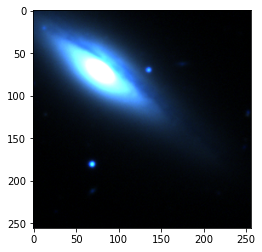

In [40]:
pl.imshow(data[0].data.T)

In [29]:
def sdss_rgb(imgs, bands, scales=None, m = 0.02):
    import numpy as np
    rgbscales = {'u': (2,1.5), #1.0,
                 'g': (2,2.5),
                 'r': (1,1.5),
                 'i': (0,1.0),
                 'z': (0,0.4), #0.3
                 }
    if scales is not None:
        rgbscales.update(scales)

    I = 0
    for img,band in zip(imgs, bands):
        plane,scale = rgbscales[band]
        img = np.maximum(0, img * scale + m)
        I = I + img
    I /= len(bands)

    # b,g,r = [rimg * rgbscales[b] for rimg,b in zip(imgs, bands)]
    # r = np.maximum(0, r + m)
    # g = np.maximum(0, g + m)
    # b = np.maximum(0, b + m)
    # I = (r+g+b)/3.
    Q = 20
    fI = np.arcsinh(Q * I) / np.sqrt(Q)
    I += (I == 0.) * 1e-6
    H,W = I.shape
    rgb = np.zeros((H,W,3), np.float32)
    for img,band in zip(imgs, bands):
        plane,scale = rgbscales[band]
        rgb[:,:,plane] = (img * scale + m) * fI / I

    rgb = np.clip(rgb, 0, 1)
    return rgb

def dr2_rgb(rimgs, bands, **ignored):
    return sdss_rgb(rimgs, bands, scales=dict(g=(2,6.0), r=(1,3.4), z=(0,2.2)), m=0.03)

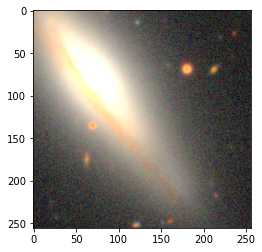

In [35]:
pl.imshow(dr2_rgb(data[0].data, 'grz'))

In [5]:
import numpy as np
from   astropy.table import Table

N_BGS = 10

ii_shuffle  = np.random.choice(N_BGS, N_BGS, replace=False)

labelclass = np.zeros(N_BGS, dtype='object')
labelclass[:int(N_BGS*.7)] = 'train'
labelclass[int(N_BGS*.7):int(N_BGS*.9)] = 'test'
labelclass[int(N_BGS*.9):] = 'valid'

labelclass

array(['train', 'train', 'train', 'train', 'train', 'train', 'train',
       'test', 'test', 'valid'], dtype=object)

In [6]:
labelTab = Table()
labelTab['LABEL'] = labelclass[ii_shuffle]
labelTab

<Table length=10>
LABEL 
object
------
 train
 train
 train
  test
  test
 train
 train
 train
 valid
 train

In [10]:
10//1, 10//2, 10//3, 10//4

(10, 5, 3, 2)

### Fix FITS files

In [80]:
from astropy.io import fits
from astropy.table import Table, join
import desispec.io

import numpy as np
import pylab as pl

In [47]:
hdict = {'a':1, 'b':2, 'c':3}

In [48]:
header = fits.Header(hdict)
header

A       =                    1                                                  
B       =                    2                                                  
C       =                    3                                                  

In [49]:
hdup = fits.PrimaryHDU(header=header)
hdup.header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
A       =                    1                                                  
B       =                    2                                                  
C       =                    3                                                  

In [50]:
image = np.zeros((100,100))
hdu1 = fits.ImageHDU(data=image)
hdu1.data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [51]:
hdul = fits.HDUList([hdup,hdu1])
hdul.writeto('new1.fits', overwrite=True)

In [52]:
hdur = fits.open('new1.fits')
hdur[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
A       =                    1                                                  
B       =                    2                                                  
C       =                    3                                                  

In [53]:
hdur[1].header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  100                                                  
NAXIS2  =                  100                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               

In [54]:
hdur[1].data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [78]:
release = 'guadalupe'
survey = 'main'
clss = 'bgs'
catalog = f'../../data/deepgn/catalog_{release}_{survey}_{clss}2'
filename = f'{catalog}/photo/train/DESI_39627541597651211_201.39770383665393-10.169522627153393.fits'

hdu = fits.open(filename)
hdu[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
TARGETID=    39627541597651211                                                  
FLUX_G  =    12.16021060943604                                                  
FLUX_R  =    20.50869178771973                                                  
FLUX_Z  =    33.08172988891602                                                  
FLUX_W1 =    28.08564186096191                                                  
FLUX_W2 =    15.40944385528564                                                  
SHAPE_R =    1.698048710823059                                                  
RATIO_BA=   0.2869619727134705                                                  

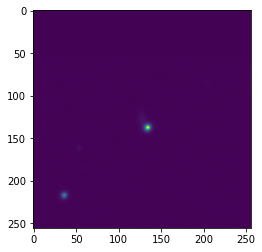

In [81]:
pl.imshow(hdu[1].data)

In [83]:
catalog = f'../../data/deepgn/catalog_{release}_{survey}_{clss}2'
data = f'{catalog}/photo_features.csv'
data = Table.read(data)
data

<Table length=825362>
     TARGETID              Z           ... LABEL       RATIO_BA     
      int64             float64        ...  str5       float64      
----------------- -------------------- ... ----- -------------------
39627541597651211  0.10465148000721934 ... train 0.28696197271347046
39627541597651384  0.20723219232576198 ... train   0.657204806804657
39627541601845289  0.34257429377805054 ... train  0.6952996253967285
39627541606039631  0.41999844048285995 ...  test 0.13739337027072906
39627541606039677   0.3323346693623744 ... train 0.48272645473480225
39627541606039880  0.22767768425646814 ... train  0.6805657148361206
39627547490648172  0.21990599447706743 ... train  0.7098605036735535
39627547490648176  0.24034261154657718 ... train  0.6128799319267273
39627547490648342   0.0688902953313014 ... train 0.44652557373046875
39627547490648764  0.18921928265323812 ... train 0.43843013048171997
              ...                  ... ...   ...                 ...
39637330885084473    0.140182594670623 ... train 0.21901285648345947
39637330885084662   0.4681153425473922 ... valid   0.851880669593811
39637330885085294   0.3456888895147781 ...  test  0.4086994528770447
39637330885085953   0.4612942421895889 ... train  0.7507374286651611
39637330885086337  0.11930735257850753 ... train 0.30655044317245483
39637330885087431  0.42164491508132684 ... train  0.5441515445709229
39637330885087784  0.16075618269700442 ... train  0.7990790605545044
39637330885087875  0.31641716071315273 ... train  0.5470945239067078
39637341018526528 0.034248581708430356 ... train 0.23366130888462067
39637341018526951   0.3168911376012401 ... train  0.5707916617393494

In [84]:
data['TARGET_RA'][data['TARGETID']==39627541597651211] #39627541597651211

<Column name='TARGET_RA' dtype='float64' length=1>
201.39770383665393

In [85]:
release_dir = desispec.io.specprod_root(release)

zpix_cat = Table.read(f'{release_dir}/zcatalog/ztile-main-bright-cumulative.fits', hdu="ZCATALOG")


#- Filter BGS
ii = ( (zpix_cat['BGS_TARGET'] != 0)
      &(zpix_cat['COADD_FIBERSTATUS'] == 0)
      &(zpix_cat['DELTACHI2'] > 40.0)
      &(zpix_cat['SPECTYPE'] == 'GALAXY')
      &(zpix_cat['ZERR'] < (5e-4*zpix_cat['Z']))
     )

#- Define ZPIX Columns
zpix_columns = ['TARGETID','Z','TARGET_RA','TARGET_DEC',
                'FLUX_G','FLUX_R','FLUX_Z','FLUX_W1','FLUX_W2',
                'SHAPE_R','SHAPE_E1','SHAPE_E2'
               ]

#- Select the BGS and selected columns
df_targets = zpix_cat[zpix_columns][ii]
N_BGS = len(df_targets)
df_targets

<Table length=1019025>
     TARGETID              Z          ...   SHAPE_E1      SHAPE_E2  
      int64             float64       ...   float32       float32   
----------------- ------------------- ... ------------ -------------
39628507101269664  0.4062205274191846 ...   -0.0953563 -0.0044281976
39628507105462923 0.16805288199402002 ...  0.027654659   0.121151455
39628512272846824    0.25354029078614 ...          0.0           0.0
39628507109656882 0.17519261917727236 ...   0.33940703    -0.1240395
39628507105462041 0.08495343815913457 ...   -0.4606843   -0.12410599
39628507105463980 0.18006858277233279 ...   0.08885137   -0.00321326
39628507101270299  0.0599970882680389 ...   -0.1517463   -0.01984694
39628507105464284 0.17750733151003972 ...  -0.03299579   -0.18031853
39628507109655173 0.23510209458975384 ...    0.0830156     0.5052458
39628507105464054  0.4292536973019069 ...          0.0           0.0
              ...                 ... ...          ...           ...
39633006465389694   0.065746070168468 ...   0.20530434   -0.16598202
39633006465386650 0.11382119755925306 ...   0.06404708  -0.090772085
39633011334974353  0.3389483271318075 ...   0.19501668   -0.12177946
39633006465385242  0.3106988051919815 ...          0.0           0.0
39633006465388425  0.2778231326741479 ...  -0.06097063    0.12515773
39633006465386603 0.22097562757947034 ...   0.44745532     -0.426669
39633011339166352 0.10117570330823535 ...          0.0           0.0
39633006465385187  0.3002986799958117 ...   -0.0799007  0.0076992023
39633006465388955 0.16562012382169125 ...  -0.09225849   -0.34568316
39633011339167916 0.26175186553608193 ... -0.049692325   -0.25692642

In [71]:
ii_shuffle  = np.random.choice(N_BGS, N_BGS, replace=False)

labelclass = np.zeros(N_BGS, dtype='object')
labelclass[:int(N_BGS*.7)] = 'train'
labelclass[int(N_BGS*.7):int(N_BGS*.9)] = 'test'
labelclass[int(N_BGS*.9):] = 'valid'

labelTab = Table()
labelTab['LABEL'] = labelclass[ii_shuffle]
labelTab['TARGETID'] = df_targets['TARGETID']

df_targets = join(df_targets, labelTab , keys=['TARGETID'])
df_targets

<Table length=1019113>
     TARGETID              Z               TARGET_RA      ...   SHAPE_E2  LABEL 
      int64             float64             float64       ...   float32   object
----------------- -------------------- ------------------ ... ----------- ------
39627541593456812   0.3828858895650519 201.27870939939396 ...         0.0  train
39627541593456841   0.2693937461232438 201.28789980339423 ...         0.0  train
39627541593456922  0.33417396509054914 201.31870132554738 ...         0.0  train
39627541597651025   0.3811646930668034  201.3501757396621 ...         0.0  train
39627541597651211  0.10465148000721934 201.39770383665393 ...  -0.0502843  train
39627541597651327    0.456801502842596 201.44794013564066 ...         0.0  train
39627541597651384  0.20723219232576198 201.47123325321365 ...  0.16416003   test
39627541597651493  0.27967143867862854 201.50990893800636 ...         0.0  train
39627541601845289  0.34257429377805054  201.6530555023779 ...  0.05173013   test
39627541606039631  0.41999844048285995 201.88315693431167 ... -0.48832852  train
              ...                  ...                ... ...         ...    ...
39637330885086337  0.11930735257850753  343.9122067995416 ... -0.20291942  train
39637330885086585  0.45797877260660724  343.9241925327469 ...         0.0  train
39637330885087431  0.42164491508132684 343.96517725350986 ...  0.27901965   test
39637330885087784  0.16075618269700442  343.9841693645073 ...  0.06598516  train
39637330885087875  0.31641716071315273 343.98897310793274 ...  0.28760064  train
39637330885088227  0.33201680936173006 344.00737229535747 ...         0.0   test
39637330885088287  0.23028925678961246  344.0102801258808 ...         0.0  train
39637330897666157  0.46765761200582856 344.63377476067643 ...         0.0  train
39637341018526528 0.034248581708430356 341.50519094093755 ...  0.08590832  train
39637341018526951   0.3168911376012401  341.5285931968522 ... -0.16663045  train

In [72]:
# #- Apply filter to remove empty data
df_targets = df_targets[(df_targets['FLUX_G'] != 0) & (df_targets['FLUX_R'] != 0) & 
                        (df_targets['FLUX_Z'] != 0) & (df_targets['FLUX_W1'] != 0) & 
                        (df_targets['FLUX_W2'] != 0) & (df_targets['SHAPE_R'] != 0) &
                        (df_targets['SHAPE_E1'] != 0) & (df_targets['SHAPE_E2'] != 0)
                       ]
df_targets

<Table length=825362>
     TARGETID              Z           ...   SHAPE_E2   LABEL 
      int64             float64        ...   float32    object
----------------- -------------------- ... ------------ ------
39627541597651211  0.10465148000721934 ...   -0.0502843  train
39627541597651384  0.20723219232576198 ...   0.16416003   test
39627541601845289  0.34257429377805054 ...   0.05173013   test
39627541606039631  0.41999844048285995 ...  -0.48832852  train
39627541606039677   0.3323346693623744 ... -0.027576078  train
39627541606039880  0.22767768425646814 ...  0.020580275  train
39627547490648172  0.21990599447706743 ...  -0.16394147  train
39627547490648176  0.24034261154657718 ...  0.092003174  train
39627547490648342   0.0688902953313014 ...    0.3824727  train
39627547490648764  0.18921928265323812 ...  -0.33893883  train
              ...                  ... ...          ...    ...
39637330885084473    0.140182594670623 ... -0.124568015  train
39637330885084662   0.4681153425473922 ...   0.07208677  train
39637330885085294   0.3456888895147781 ...   0.40623188  train
39637330885085953   0.4612942421895889 ...  0.058223385  train
39637330885086337  0.11930735257850753 ...  -0.20291942  train
39637330885087431  0.42164491508132684 ...   0.27901965   test
39637330885087784  0.16075618269700442 ...   0.06598516  train
39637330885087875  0.31641716071315273 ...   0.28760064  train
39637341018526528 0.034248581708430356 ...   0.08590832  train
39637341018526951   0.3168911376012401 ...  -0.16663045  train

In [75]:
df_targets.write('test.csv', overwrite=True)

In [77]:
data_new = Table.read('test.csv')
data_new

<Table length=825362>
     TARGETID              Z           ...        SHAPE_E2       LABEL
      int64             float64        ...        float64         str5
----------------- -------------------- ... --------------------- -----
39627541597651211  0.10465148000721934 ...  -0.05028429999947548 train
39627541597651384  0.20723219232576198 ...   0.16416002810001373  test
39627541601845289  0.34257429377805054 ...   0.05173012986779213  test
39627541606039631  0.41999844048285995 ...   -0.4883285164833069 train
39627541606039677   0.3323346693623744 ... -0.027576077729463577 train
39627541606039880  0.22767768425646814 ...  0.020580274984240532 train
39627547490648172  0.21990599447706743 ...  -0.16394147276878357 train
39627547490648176  0.24034261154657718 ...   0.09200317412614822 train
39627547490648342   0.0688902953313014 ...    0.3824726939201355 train
39627547490648764  0.18921928265323812 ...     -0.33893883228302 train
              ...                  ... ...                   ...   ...
39637330885084473    0.140182594670623 ...  -0.12456801533699036 train
39637330885084662   0.4681153425473922 ...   0.07208676636219025 train
39637330885085294   0.3456888895147781 ...    0.4062318801879883 train
39637330885085953   0.4612942421895889 ...  0.058223385363817215 train
39637330885086337  0.11930735257850753 ...  -0.20291942358016968 train
39637330885087431  0.42164491508132684 ...   0.27901965379714966  test
39637330885087784  0.16075618269700442 ...   0.06598515808582306 train
39637330885087875  0.31641716071315273 ...   0.28760063648223877 train
39637341018526528 0.034248581708430356 ...   0.08590832352638245 train
39637341018526951   0.3168911376012401 ...  -0.16663044691085815 train

In [ ]:
import numpy as np

block = 30

AA = np.array([0,858000])
BB = np.linspace(AA[0],AA[1],30, dtype=int)
NN = len(BB)-1
CC = np.zeros(NN, dtype=object)
for i in range(NN):
    CC[i] = np.array([BB[i],BB[i+1]])

CC

In [1]:
import numpy as np
from glob import glob

In [11]:
data = glob('../../data/deepgn/catalog_guadalupe_main_bgs/npy/*')

In [13]:
data

[]

In [1]:
from astropy.io import fits
from astropy.table import Table
    
import pylab as pl

import numpy  as np 
import pandas as pd

import src.plotting_tools as plt_tools

pl.style.use('/pscratch/sd/j/jfsuarez/plots.mplstyle')

In [2]:
data = Table.read('../../data/deepgn/catalog_guadalupe_main_bgst/photo_features.csv')
data

<Table length=825362>
     TARGETID              Z           ... LABEL       RATIO_BA     
      int64             float64        ...  str5       float64      
----------------- -------------------- ... ----- -------------------
39627541597651211  0.10465148000721934 ... train 0.28696197271347046
39627541597651384  0.20723219232576198 ... train   0.657204806804657
39627541601845289  0.34257429377805054 ... train  0.6952996253967285
39627541606039631  0.41999844048285995 ...  test 0.13739337027072906
39627541606039677   0.3323346693623744 ... train 0.48272645473480225
39627541606039880  0.22767768425646814 ... train  0.6805657148361206
39627547490648172  0.21990599447706743 ... train  0.7098605036735535
39627547490648176  0.24034261154657718 ... train  0.6128799319267273
39627547490648342   0.0688902953313014 ... train 0.44652557373046875
39627547490648764  0.18921928265323812 ... train 0.43843013048171997
              ...                  ... ...   ...                 ...
39637330885084473    0.140182594670623 ... train 0.21901285648345947
39637330885084662   0.4681153425473922 ... valid   0.851880669593811
39637330885085294   0.3456888895147781 ...  test  0.4086994528770447
39637330885085953   0.4612942421895889 ... train  0.7507374286651611
39637330885086337  0.11930735257850753 ... train 0.30655044317245483
39637330885087431  0.42164491508132684 ... train  0.5441515445709229
39637330885087784  0.16075618269700442 ... train  0.7990790605545044
39637330885087875  0.31641716071315273 ... train  0.5470945239067078
39637341018526528 0.034248581708430356 ... train 0.23366130888462067
39637341018526951   0.3168911376012401 ... train  0.5707916617393494

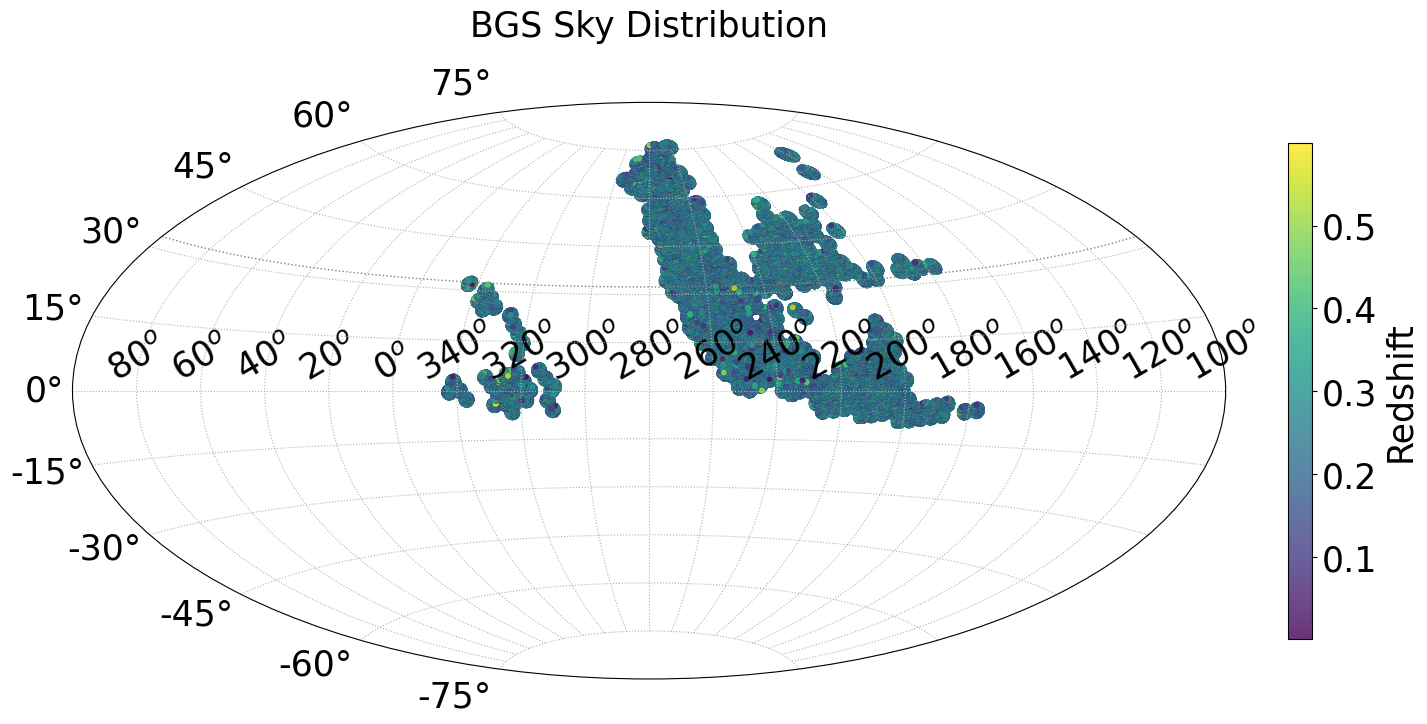

In [3]:
ii = np.array(data['Z'])<0.6
fig = plt_tools.plot_skymap(data['TARGET_RA'][ii], data['TARGET_DEC'][ii], data['Z'][ii], field_str='Redshift', title='BGS Sky Distribution', ptsize=10)   
fig.show()

In [5]:
fig.savefig('./paper_figs/fig2.1_BGSSky.png', bbox_inches='tight')
fig.savefig('./paper_figs/fig2.1_BGSSky.pdf', bbox_inches='tight')

In [1]:
loss = [1,2,3,4]
max(loss)

4

In [1]:
import pylab as pl

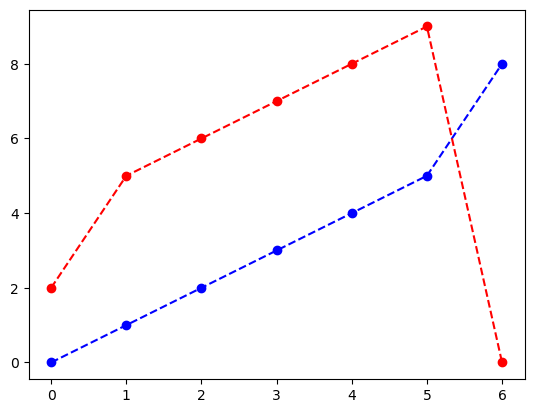

In [5]:
A =  [0,1,2,3,4,5,8]
B =  [2,5,6,7,8,9,0]
pl.plot(A, 'bo--')
pl.plot(B, 'ro--')

In [1]:
import numpy as np
import os 
import argparse
import pylab as pl
from   glob import glob
from   PIL import Image
from   astropy.io import fits
from   astropy.table import Table

import torch
from torch            import nn
from torch            import FloatTensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn         import functional as F
from torchvision      import transforms
from torchvision.models import feature_extraction
from torchvision.models import vit_l_16,  ViT_L_16_Weights
from torchvision.models import vit_l_32,  ViT_L_32_Weights
from torchvision.models import swin_b, Swin_B_Weights
from torchvision.models import swin_s, Swin_S_Weights
from torchvision.models import swin_t, Swin_T_Weights
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import resnet152, ResNet152_Weights


In [2]:
class GalaxyNet(torch.nn.Module):
    def __init__(self, pretrained=True, modelname='swins', lf=0):
        super().__init__()
        #print('hiii', model)
        if modelname=='vitl16':
            model = vit_l_16(weights=ViT_L_16_Weights.DEFAULT)
        elif modelname=='vitl32':
            model = vit_l_32(weights=ViT_L_32_Weights.DEFAULT)
        elif modelname=='swinb':
            model = swin_b(weights=Swin_B_Weights.DEFAULT)
        elif modelname=='swins':
            model = swin_s(weights=Swin_S_Weights.DEFAULT)
        elif modelname=='swint':
            model = swin_t(weights=Swin_T_Weights.DEFAULT)
        elif modelname=='resnet18':
            model = resnet18(weights=ResNet18_Weights.DEFAULT)
        elif modelname=='resnet50':
            model = resnet50(weights=ResNet50_Weights.DEFAULT)
        elif modelname=='resnet152':
            model = resnet152(weights=ResNet152_Weights.DEFAULT)

        else:
            print('Other model doesnt exist')
        
        count = 0
        #print(model)
        for child in model.children():  
            count += 1
            if count <= lf:    
                for param in child.parameters():
                    param.requires_grad = False

        # for param in model.parameters():
        #     param.requires_grad = False        
        
        model.load_state_dict(model.state_dict())     
        
        self.features = torch.nn.ModuleList(model.children())[:-1]
        self.features = torch.nn.Sequential(*self.features)
        
        if 'swin' in modelname:
            self.fc1 = torch.nn.Linear(model.head.in_features, 768)
            self.fc2 = torch.nn.Linear(768, 256)
            
        elif 'vit' in modelname:
            self.fc1 = torch.nn.Linear(model.heads.head.in_features, 768)
            self.fc2 = torch.nn.Linear(768, 256)
            
        elif 'resnet' in modelname:
            self.fc1 = torch.nn.Linear(model.fc.in_features, 512)
            self.fc2 = torch.nn.Linear(512, 256)

        self.fc3 = torch.nn.Linear(256, 1)        
        
    def forward(self, x):
        #-Call Features
        x = self.features(x)
        
        #-Flatten
        x = x.view(x.size(0), -1)
        
        # and also our new layers 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [3]:
GalaxyNet(modelname='swins')

GalaxyNet(
  (features): Sequential(
    (0): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): Permute()
        (2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      )
      (1): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): ShiftedWindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (proj): Linear(in_features=96, out_features=96, bias=True)
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): MLP(
            (0): Linear(in_features=96, out_features=384, bias=True)
            (1): GELU(approximate='none')
            (2): Dropout(p=0.0, inplace=False)
            (3): Linear(in_features=384, out_features=96, bias=True)
            (4): Dropout(p=0.0, inplace=False)
   

In [12]:
import numpy as np

A = ['1','2','3','4','5']
B = ['7','5','8','5','4']
min(A)

'1'

In [13]:
B[A==min(A)]

'7'

In [16]:
f'{float(min(A)):.2f}Holi {float(B[A==min(A)]):.2f}Chawi'

'1.00Holi 7.00Chawi'

In [6]:
from astropy.table import Table
from src.utils import mw_transmission
from src.utils import mag
from src.utils import metrics

catalog = './../../data/deepgn/catalog_guadalupe_main_bgs_jpg/photo_features_full.csv'

Z_lim = 0.6

print('Reading the catalog...')
data = Table.read(catalog)
#################### BGS Brigth ##################
magr_lim = 19.5
MAG_R  =  mag(data['FLUX_R'], data['EBV'], 'R')
Z      =  data['Z']
#################### BGS Brigth ##################    

Reading the catalog...


In [7]:
import pylab as pl

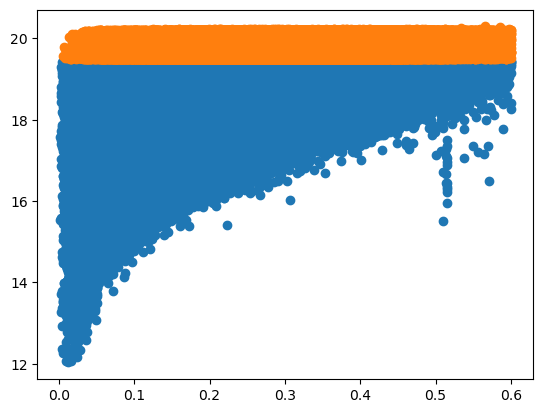

In [9]:
ii_b = (MAG_R<magr_lim) & (Z<Z_lim)
ii_f = (MAG_R>magr_lim) & (Z<Z_lim)
pl.scatter(Z[ii_b], MAG_R[ii_b])
pl.scatter(Z[ii_f], MAG_R[ii_f])

In [1]:
#!/usr/bin/env python

import numpy as np
import os 
import argparse
import pylab as pl
from   glob import glob
from   PIL import Image
from   astropy.io import fits
from   astropy.table import Table

import torch
import lightning.pytorch as lp
from torch            import nn
from torch            import FloatTensor
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn         import functional as F
from torchvision      import transforms
from torchvision.models import feature_extraction
from torchvision.models import vit_l_16,  ViT_L_16_Weights
from torchvision.models import vit_l_32,  ViT_L_32_Weights
from torchvision.models import swin_b, Swin_B_Weights
from torchvision.models import swin_s, Swin_S_Weights
from torchvision.models import swin_t, Swin_T_Weights
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.models import resnet152, ResNet152_Weights

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from src.utils import mw_transmission
from src.utils import mag
from src.utils import metrics

In [24]:
pl.style.use('/pscratch/sd/j/jfsuarez/plots.mplstyle')

print("torch_version: ",torch.__version__)
print("numpy_version: ",np.__version__)
print("Lighthing_version: ",lp.__version__)

class GalaxyNet(lp.LightningModule):
    def __init__(self, pretrained=True, modelname='swins', lf=0, lr=1e-3):
        super().__init__()
        #print('hiii', model)
        if modelname=='vitl16':
            self.model = vit_l_16(weights=ViT_L_16_Weights.DEFAULT)
        elif modelname=='vitl32':
            self.model = vit_l_32(weights=ViT_L_32_Weights.DEFAULT)
        elif modelname=='swinb':
            self.model = swin_b(weights=Swin_B_Weights.DEFAULT)
        elif modelname=='swins':
            self.model = swin_s(weights=Swin_S_Weights.DEFAULT)
        elif modelname=='swint':
            self.model = swin_t(weights=Swin_T_Weights.DEFAULT)
        elif modelname=='resnet18':
            self.model = resnet18(weights=ResNet18_Weights.DEFAULT)
        elif modelname=='resnet50':
            self.model = resnet50(weights=ResNet50_Weights.DEFAULT)
        elif modelname=='resnet152':
            self.model = resnet152(weights=ResNet152_Weights.DEFAULT)

        else:
            print('Other model doesnt exist')
        
        self.lf = lf
        self.lr = lr
        
        count = 0
        #print(model)
        for child in self.model.children():  
            count += 1
            if count <= self.lf:    
                for param in child.parameters():
                    param.requires_grad = False

        # for param in model.parameters():
        #     param.requires_grad = False        
        
        self.model.load_state_dict(self.model.state_dict())     
        
        self.features = torch.nn.ModuleList(self.model.children())[:-1]
        self.features = torch.nn.Sequential(*self.features)
        
        if 'swin' in modelname:
            self.fc1 = torch.nn.Linear(self.model.head.in_features, 768)
            self.fc2 = torch.nn.Linear(768, 256)
            
        elif 'vit' in modelname:
            self.fc1 = torch.nn.Linear(self.model.heads.head.in_features, 768)
            self.fc2 = torch.nn.Linear(768, 256)
            
        elif 'resnet' in modelname:
            self.fc1 = torch.nn.Linear(self.model.fc.in_features, 512)
            self.fc2 = torch.nn.Linear(512, 256)

        self.fc3 = torch.nn.Linear(256, 1)        
        
    def forward(self, x):
        #-Call Features
        x = self.features(x)
        
        #-Flatten
        x = x.view(x.size(0), -1)
        
        # and also our new layers 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x
    
    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=self.lr)
        return optimizer
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        # x = x.view(x.size(0), -1)
        x = x.squeeze()
        
        #- Make the prediction
        y_hat = self.model(x).squeeze()
        
        #- Compute the loss
        loss = torch.nn.MSELoss(y_hat, y, on_epoch=True)
        self.log('train_log', loss)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        # x = x.view(x.size(0), -1)
        x = x.squeeze()
        
        #- Make the prediction
        y_hat = self.model(x).squeeze()
        
        #- Compute the loss
        loss = torch.nn.MSELoss(y_hat, y)
        self.log('valid_log', loss)
          
        
#     def backward(self, trainer, loss, optimizer, optimizer_idx):
#         loss.backward()
        
#     def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx):
#         optmizer.step()
        

torch_version:  1.13.1.post200
numpy_version:  1.24.3
Lighthing_version:  2.0.2


In [25]:
def tensor2img(tensor):
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    img_restore = tensor * torch.tensor(std).view(3, 1, 1) + torch.tensor(mean).view(3, 1, 1)
    return transforms.ToPILImage()(img_restore)

class ReadDataset(Dataset):
    def __init__(self, data_paths, data):
        self.data_files = data_paths 
        self.data = data
        self.data_transforms = transforms.Compose([
            # transforms.Resize(256),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])
    
    def __getitem__(self, index):
        TID = int(self.data_files[index].split('/')[-1].split('_')[1])
        #print(TID)
        #print(self.data_files[index])
        x = fits.open(self.data_files[index])
        #print(x)
        x = x[4].data
        #print(x, type(x))
        x = self.data_transforms(x)
        #print(x)
        
        y = np.array(self.data['Z'][self.data['TARGETID']==TID], dtype=float)[0]
        y = torch.tensor(y).float()
        #print(x,y)
        return x, y
    
    def __len__(self):
        return len(self.data_files)

In [26]:
def main():
    #- Define the device cpu/gpu
    device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
    print(device)    
    
    #- Set parameters
    parser = argparse.ArgumentParser()
    parser.add_argument('--lr', type=float, default=1e-2,
                        help='Initial learning rate (default: 1e-3)')
    
    parser.add_argument('--epochs', type=int, default=100,
                        help='Maximum number of epochs (default: 300)')
    
    parser.add_argument('--batch', type=int, default=16,
                        help='Batch size (default: 13)')
    
    parser.add_argument('--name', type=str, default='Test',
                        help='Name of the current test (default: Test)')
    
    parser.add_argument('--lf', type=int, default=0,
                        help='Layers Frozen')
    
    parser.add_argument('--dropout', type=float, default=0.3, 
                        help='Dropout probability')
    
    parser.add_argument('--model', type=str, default='resnet50',
                        help='cnn/resnet')
    
    parser.add_argument('--label', type=str, default='Test',
                        help='Label to compare runnings')
    
    parser.add_argument('--catalog', type=str, default=None, 
                        help='Name of the folder with the data')
    
   
    # args = parser.parse_args()
    # batch_size = args.batch
    # name       = args.name 
    # label      = args.label
    # catalog    = args.catalog
    # modelname  = args.model
    # lr         = args.lr
    # lf         = args.lf
    # epochs     = args.epochs
    
    batch_size = 32
    name       = 'test'
    label      = 'test'
    catalog    = './../../data/deepgn/catalog_guadalupe_main_bgs_jpg/photo_features_full.csv'
    modelname  = 'resnet50'
    lr         = 0.01
    lf         = 0
    epochs     = 100
       
    save_path = os.path.join('../model','deepgn','train', name, label)
    if not os.path.isdir(save_path):
        os.makedirs(save_path, exist_ok=True)
        
    checkpoint_file = f'{save_path}/model_checkpoint.pt'
    Z_lim = 0.6

    print('Reading the catalog...')
    data = Table.read(catalog)
    data = data[(data['Z']<Z_lim) & (data['FLUX_W1']>0) & (data['FLUX_W2']>0)]
    
    #################### BGS Brigth ##################
    # magr_lim = 19.5
    # MAG_R  =  mag(data['FLUX_R'], data['EBV'], 'R')
    # data = data[(MAG_R<magr_lim)]
    #################### BGS Brigth ##################    
    
    dirdata = catalog[:catalog.rfind('/')]

    def pathfit(lab,tid,ra,dec):
        if dec>0:
            file = f'{dirdata}/photo/{lab}/DESI_{tid}_{float(ra)}+{float(dec)}.fits'
        else:
            file = f'{dirdata}/photo/{lab}/DESI_{tid}_{float(ra)}{float(dec)}.fits'
        return file

    train_files = []
    test_files  = []
    valid_files = []

    for i in range(len(data)):
        d = data[i]
        if d['LABEL']=='train':
            train_files.append(pathfit(d['LABEL'], d['TARGETID'], d['TARGET_RA'], d['TARGET_DEC']))
        elif d['LABEL']=='valid':
            valid_files.append(pathfit(d['LABEL'], d['TARGETID'], d['TARGET_RA'], d['TARGET_DEC']))
        elif d['LABEL']=='test':
            test_files.append(pathfit(d['LABEL'], d['TARGETID'], d['TARGET_RA'], d['TARGET_DEC']))

    #- Number of objects
    N = len(train_files)+len(valid_files)+len(test_files)
    print(f'#####\n There are {N} objects\n#####')

    print(f'#######\n Train Size: {len(train_files)}')
    print(f' Valid  Size: {len(valid_files)}')
    print(f' Test  Size: {len(test_files)}\n#######')
    
    #train_files = train_files[:1000]
    #valid_files = valid_files[:100]
    #test_files  = test_files[:100]

    train_dataset = ReadDataset(train_files, data)
    valid_dataset = ReadDataset(valid_files, data)
    test_dataset  = ReadDataset(test_files, data)
    
    #print(train_dataset[0])
    
    # sample_idx = torch.randint(0, len(train_dataset), size=(9,)).detach().numpy()
    # figure = pl.figure(figsize=(8, 8))
    # cols, rows = 3, 3
    # for i in range(0, cols * rows):
    #     spec, tgt = train_dataset[sample_idx[i]]
    #     figure.add_subplot(rows, cols, i+1)
    #     pl.title(f'Z {tgt.item():.4f}')
    #     pl.plot(spec.squeeze())
    # print(f'Size {len(spec.squeeze())}')
    # pl.tight_layout()
    # pl.savefig()
    # pl.show()
    
    #- Define the batch_size
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=True)
    
    #print(test_dataloader)
    
    # train_features, train_labels = next(iter(train_dataloader))
    #- Display image and label
    # spec = train_features[0].squeeze().detach().numpy()
    # label = train_labels[0].item()
    # pl.title(f'Z {label:.4f}')
    # pl.plot(spec)
    # pl.show()

    #- Define the device cpu/gpu
    device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
    print(device)

    #- Define the model
    model   = GalaxyNet(modelname='resnet18', lf=lf, lr=lr)
    trainer = lp.Trainer(limit_train_batches=batch_size, max_epochs=epochs, default_root_dir="./test")
    # print(model.parameters)
    trainer.fit(model, train_dataloader, valid_dataloader)

In [27]:
if __name__ == '__main__':
    print('Starting...')
    main()

Starting...
cuda:0
Reading the catalog...


/global/homes/j/jfsuarez/.conda/envs/deepgn/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:165: PossibleUserWarning: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /global/homes/j/jfsuarez/.conda/envs/deepgn/lib/pyth ...
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
---------

#####
 There are 818360 objects
#####
#######
 Train Size: 573016
 Valid  Size: 81783
 Test  Size: 163561
#######
cuda:0


/global/homes/j/jfsuarez/.conda/envs/deepgn/lib/python3.9/site-packages/lightning/fabric/loggers/csv_logs.py:188: UserWarning: Experiment logs directory test/lightning_logs/version_0 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(


Sanity Checking: 0it [00:00, ?it/s]

/global/homes/j/jfsuarez/.conda/envs/deepgn/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/global/homes/j/jfsuarez/.conda/envs/deepgn/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


RuntimeError: Boolean value of Tensor with more than one value is ambiguous